画像切り抜き処理を追加  

VGG16ベースのファインチューニング

In [1]:
# パッケージのimport
import re
import glob
import os.path as osp
import os
import pandas as pd
import random
import numpy as np
import json
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision
from torchvision import models, transforms

In [2]:
# from google.colab import drive
# drive.mount('./gdrive', force_remount=True)

In [3]:
! pip3 install signate

     |████████████████████████████████| 138 kB 3.0 MB/s 
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=5d58908ba7d379aa25f0f71aa9ff4f3fc7050c115720481289306913ae5829e7
  Stored in directory: /root/.cache/pip/wheels/a1/b6/7c/0e63e34eb06634181c63adacca38b79ff8f35c37e3c13e3c02
Successfully built wget
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
requests 2.23.0 requires urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1, but you have urllib3 1.26.7 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [4]:
! signate token --email=yakiniku0831@gmail.com --password=md2yMqU8X9JJAq2


The API Token has been downloaded successfully.


In [5]:
! signate list

  competitionId  title                                                                                  closing     prize            submitters
---------------  -------------------------------------------------------------------------------------  ----------  -------------  ------------
              1  【練習問題】銀行の顧客ターゲティング                                                   -                                  5170
             24  【練習問題】お弁当の需要予測                                                           -                                  6340
             27  【練習問題】Jリーグの観客動員数予測                                                    -                                  1433
            100  【練習問題】手書き文字認識                                                             -           Knowledge               173
            102  【練習問題】タイタニックの生存予測                                                     -           Knowledge              1061
            103  【練習問題】音楽ラベリング                                         

In [6]:
! signate files --competition-id=499

  fileId  name                                           title                                                size  updated_at
--------  ---------------------------------------------  ----------------------------------------------  ---------  -------------------
    2219  PBL02_h_exercise4_question.pdf                 PBL02_不良個所自動検出_h.演習④設問                1417656  2021-08-19 15:22:04
    2220  PBL02_i_exercise4_supplementary-documents.pdf  PBL02_不良個所自動検出_i.演習④ガイドコンテンツ     470147  2021-08-19 15:22:07
    2138  train.zip                                      学習用画像データ                                183977509  2021-08-19 15:22:07
    2139  test.zip                                       評価用画像データ                                151304061  2021-08-19 15:22:07
    2140  train_master.tsv                               学習用画像データとラベルIDの対応表                   5221  2021-08-19 15:22:07
    2141  sample_submit.tsv                              応募用サンプルファイル                                100  2021-08-19 15:

In [7]:
! signate download --competition-id=499

sample_submit.tsv

requirements.txt

train_master.tsv

PBL02_sample_code.ipynb

PBL02_i_exercise4_supplementary-documents.pdf

PBL02_h_exercise4_question.pdf

test.zip

train.zip


Download completed.


In [8]:
print(torch.cuda.is_available())

True


In [315]:
#!rm -r ./Data

In [316]:
!mkdir -p ./Data/kiban/
!unzip -o ./train.zip -d ./Data/kiban/
!unzip -o ./test.zip -d ./Data/kiban/
!cp ./train_master.tsv ./Data/kiban/

Archive:  ./train.zip
   creating: ./Data/kiban/train/
   creating: ./Data/kiban/train/bridge/
  inflating: ./Data/kiban/train/bridge/bridge_000.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_001.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_002.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_003.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_004.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_005.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_006.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_007.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_008.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_009.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_010.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_011.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_012.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_013.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_014.jpeg  
  inflating: ./Data/kiban/train/bridge/bridge_015.

In [317]:
# validation用のフォルダを作成
!mkdir -p ./Data/kiban/valid/
!mkdir -p ./Data/kiban/valid/regular/
!mkdir -p ./Data/kiban/valid/potato/
!mkdir -p ./Data/kiban/valid/horn/
!mkdir -p ./Data/kiban/valid/bridge/

resizeした画像を保存

In [318]:
import cv2
from google.colab.patches import cv2_imshow

In [319]:
# img = cv2.imread(train_dir + '/regular/regular_000.jpeg')
# dst = cv2.resize(img, dsize=(224, 224))

# print(f"{img.shape} -> {dst.shape}")
# # plt.imshow(dst)

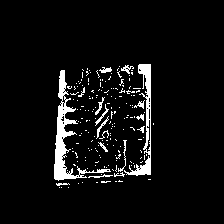

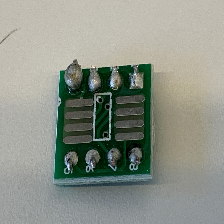

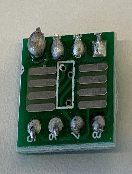

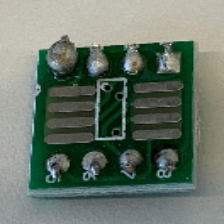

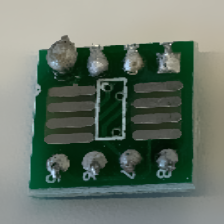

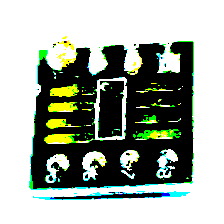

In [320]:
# 2値画像はVGG16だめらしい
# https://discuss.pytorch.org/t/runtimeerror-given-groups-1-weight-of-size-64-3-7-7-expected-input-3-1-224-224-to-have-3-channels-but-got-1-channels-instead/30153/3

image_path = './Data/kiban/train/potato/potato_032.jpeg'
img = cv2.imread(image_path)
img = cv2.resize(img, dsize=(224, 224))

img_g = cv2.imread(image_path,0)
img_g = cv2.resize(img_g, dsize=(224, 224))

hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
# 緑色を抜き出す, 下限値、上限値を指定する
# hsv空間は、hは通常のhueの半分の値（openCV上では）
# 下の例だと、hue20-50が抽出される（svは100/255%）
lower = np.array([30, 50, 50])
upper = np.array([90,255,255])
# マスク画像作成(緑色ぽい色の部分が2値化画像で保存される)
img_mask = cv2.inRange(hsv, lower, upper)

retval = cv2.boundingRect(img_mask) 

top = int(retval[1] * 0.5)
bottom = int((retval[1] + retval[3]) * 1.1)
left = int(retval[0] * 0.7)
right = int((retval[0] + retval[2]) * 1.1)

img_cut = img[top : bottom , left : right]
dst = cv2.resize(img_cut, dsize=(224, 224))

img_bi = cv2.bilateralFilter(dst, 20, 30, 30)

threshold = 80

# retにはthreshold値, img_thには画像が入る
ret, img_th = cv2.threshold(img_bi, threshold, 255, cv2.THRESH_BINARY)

cv2_imshow(img_mask)
cv2_imshow(img)
cv2_imshow(img_cut )
cv2_imshow(dst)
cv2_imshow(img_bi)
cv2_imshow(img_th)

In [321]:
# 2値画像、resizeと切り抜きの関数
def image_resize_cut(image_path):
  img = cv2.imread(image_path)
  img = cv2.resize(img, dsize=(224, 224))

  img_g = cv2.imread(image_path,0)
  img_g = cv2.resize(img_g, dsize=(224, 224))

  hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
  # 緑色を抜き出す, 下限値、上限値を指定する
  # hsv空間は、hは通常のhueの半分の値（openCV上では）
  # 下の例だと、hue20-50が抽出される（svは100/255%）
  lower = np.array([30, 50, 50])
  upper = np.array([90,255,255])
  # マスク画像作成(緑色ぽい色の部分が2値化画像で保存される)
  img_mask = cv2.inRange(hsv, lower, upper)

  retval = cv2.boundingRect(img_mask) 
  
  top = int(retval[1] * 0.5)
  bottom = int((retval[1] + retval[3]) * 1.1)
  left = int(retval[0] * 0.7)
  right = int((retval[0] + retval[2]) * 1.1)

  img_cut = img[top : bottom , left : right]
  dst = cv2.resize(img_cut, dsize=(224, 224))

  img_bi = cv2.bilateralFilter(dst, 20, 30, 30)

  # threshold = 70

  # # retにはthreshold値, img_thには画像が入る
  # ret, img_th = cv2.threshold(img_bi, threshold, 255, cv2.THRESH_BINARY)
  


  # dst = cv2.resize(, dsize=(224, 224))
  print(f"{img.shape} -> {dst.shape}")
  cv2.imwrite(image_path, img_bi)

In [322]:
# image_resize_cut(image_path)

In [323]:
path1 = glob.glob('./Data/kiban/*/*/*.jpeg')
_path2 = glob.glob('./Data/kiban/*/*.jpeg')

path1.extend(_path2)

In [324]:
path1

['./Data/kiban/train/bridge/bridge_022.jpeg',
 './Data/kiban/train/bridge/bridge_014.jpeg',
 './Data/kiban/train/bridge/bridge_019.jpeg',
 './Data/kiban/train/bridge/bridge_029.jpeg',
 './Data/kiban/train/bridge/bridge_023.jpeg',
 './Data/kiban/train/bridge/bridge_005.jpeg',
 './Data/kiban/train/bridge/bridge_008.jpeg',
 './Data/kiban/train/bridge/bridge_020.jpeg',
 './Data/kiban/train/bridge/bridge_025.jpeg',
 './Data/kiban/train/bridge/bridge_006.jpeg',
 './Data/kiban/train/bridge/bridge_024.jpeg',
 './Data/kiban/train/bridge/bridge_012.jpeg',
 './Data/kiban/train/bridge/bridge_003.jpeg',
 './Data/kiban/train/bridge/bridge_002.jpeg',
 './Data/kiban/train/bridge/bridge_021.jpeg',
 './Data/kiban/train/bridge/bridge_013.jpeg',
 './Data/kiban/train/bridge/bridge_016.jpeg',
 './Data/kiban/train/bridge/bridge_028.jpeg',
 './Data/kiban/train/bridge/bridge_004.jpeg',
 './Data/kiban/train/bridge/bridge_001.jpeg',
 './Data/kiban/train/bridge/bridge_010.jpeg',
 './Data/kiban/train/bridge/bridge

In [325]:
for i, path in tqdm(enumerate(path1)):
  # print(path)
  image_resize_cut(path)

1it [00:00,  4.00it/s]

(224, 224, 3) -> (224, 224, 3)


2it [00:00,  3.67it/s]

(224, 224, 3) -> (224, 224, 3)


3it [00:00,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


4it [00:01,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


5it [00:01,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


6it [00:01,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


7it [00:01,  3.73it/s]

(224, 224, 3) -> (224, 224, 3)


8it [00:02,  3.69it/s]

(224, 224, 3) -> (224, 224, 3)


9it [00:02,  3.73it/s]

(224, 224, 3) -> (224, 224, 3)


10it [00:02,  3.75it/s]

(224, 224, 3) -> (224, 224, 3)


11it [00:02,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


12it [00:03,  3.84it/s]

(224, 224, 3) -> (224, 224, 3)


13it [00:03,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


14it [00:03,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


15it [00:03,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


16it [00:04,  3.77it/s]

(224, 224, 3) -> (224, 224, 3)


17it [00:04,  3.72it/s]

(224, 224, 3) -> (224, 224, 3)


18it [00:04,  3.70it/s]

(224, 224, 3) -> (224, 224, 3)


19it [00:05,  3.71it/s]

(224, 224, 3) -> (224, 224, 3)


20it [00:05,  3.77it/s]

(224, 224, 3) -> (224, 224, 3)


21it [00:05,  3.74it/s]

(224, 224, 3) -> (224, 224, 3)


22it [00:05,  3.75it/s]

(224, 224, 3) -> (224, 224, 3)


23it [00:06,  3.69it/s]

(224, 224, 3) -> (224, 224, 3)


24it [00:06,  3.71it/s]

(224, 224, 3) -> (224, 224, 3)


25it [00:06,  3.72it/s]

(224, 224, 3) -> (224, 224, 3)


26it [00:06,  3.76it/s]

(224, 224, 3) -> (224, 224, 3)


27it [00:07,  3.78it/s]

(224, 224, 3) -> (224, 224, 3)


28it [00:07,  3.79it/s]

(224, 224, 3) -> (224, 224, 3)


29it [00:07,  3.71it/s]

(224, 224, 3) -> (224, 224, 3)


30it [00:07,  3.78it/s]

(224, 224, 3) -> (224, 224, 3)


31it [00:08,  3.74it/s]

(224, 224, 3) -> (224, 224, 3)


32it [00:08,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


33it [00:08,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


34it [00:09,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


35it [00:09,  3.84it/s]

(224, 224, 3) -> (224, 224, 3)


36it [00:09,  3.78it/s]

(224, 224, 3) -> (224, 224, 3)


37it [00:09,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


38it [00:10,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


39it [00:10,  3.78it/s]

(224, 224, 3) -> (224, 224, 3)


40it [00:10,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


41it [00:10,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


42it [00:11,  3.78it/s]

(224, 224, 3) -> (224, 224, 3)


43it [00:11,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


44it [00:11,  3.90it/s]

(224, 224, 3) -> (224, 224, 3)


45it [00:11,  3.90it/s]

(224, 224, 3) -> (224, 224, 3)


46it [00:12,  3.84it/s]

(224, 224, 3) -> (224, 224, 3)


47it [00:12,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


48it [00:12,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


49it [00:12,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


50it [00:13,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


51it [00:13,  3.89it/s]

(224, 224, 3) -> (224, 224, 3)


52it [00:13,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


53it [00:13,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


54it [00:14,  3.77it/s]

(224, 224, 3) -> (224, 224, 3)


55it [00:14,  3.75it/s]

(224, 224, 3) -> (224, 224, 3)


56it [00:14,  3.73it/s]

(224, 224, 3) -> (224, 224, 3)


57it [00:15,  3.76it/s]

(224, 224, 3) -> (224, 224, 3)


58it [00:15,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


59it [00:15,  3.77it/s]

(224, 224, 3) -> (224, 224, 3)


60it [00:15,  3.75it/s]

(224, 224, 3) -> (224, 224, 3)


61it [00:16,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


62it [00:16,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


63it [00:16,  3.89it/s]

(224, 224, 3) -> (224, 224, 3)


64it [00:16,  3.84it/s]

(224, 224, 3) -> (224, 224, 3)


65it [00:17,  3.87it/s]

(224, 224, 3) -> (224, 224, 3)


66it [00:17,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


67it [00:17,  3.79it/s]

(224, 224, 3) -> (224, 224, 3)


68it [00:17,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


69it [00:18,  3.78it/s]

(224, 224, 3) -> (224, 224, 3)


70it [00:18,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


71it [00:18,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


72it [00:18,  3.78it/s]

(224, 224, 3) -> (224, 224, 3)


73it [00:19,  3.75it/s]

(224, 224, 3) -> (224, 224, 3)


74it [00:19,  3.75it/s]

(224, 224, 3) -> (224, 224, 3)


75it [00:19,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


76it [00:20,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


77it [00:20,  3.92it/s]

(224, 224, 3) -> (224, 224, 3)


78it [00:20,  3.87it/s]

(224, 224, 3) -> (224, 224, 3)


79it [00:20,  3.79it/s]

(224, 224, 3) -> (224, 224, 3)


80it [00:21,  3.77it/s]

(224, 224, 3) -> (224, 224, 3)


81it [00:21,  3.76it/s]

(224, 224, 3) -> (224, 224, 3)


82it [00:21,  3.76it/s]

(224, 224, 3) -> (224, 224, 3)


83it [00:21,  3.76it/s]

(224, 224, 3) -> (224, 224, 3)


84it [00:22,  3.72it/s]

(224, 224, 3) -> (224, 224, 3)


85it [00:22,  3.79it/s]

(224, 224, 3) -> (224, 224, 3)


86it [00:22,  3.79it/s]

(224, 224, 3) -> (224, 224, 3)


87it [00:22,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


88it [00:23,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


89it [00:23,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


90it [00:23,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


91it [00:23,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


92it [00:24,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


93it [00:24,  3.90it/s]

(224, 224, 3) -> (224, 224, 3)


94it [00:24,  3.84it/s]

(224, 224, 3) -> (224, 224, 3)


95it [00:24,  3.84it/s]

(224, 224, 3) -> (224, 224, 3)


96it [00:25,  3.90it/s]

(224, 224, 3) -> (224, 224, 3)


97it [00:25,  3.84it/s]

(224, 224, 3) -> (224, 224, 3)


98it [00:25,  3.89it/s]

(224, 224, 3) -> (224, 224, 3)


99it [00:26,  3.90it/s]

(224, 224, 3) -> (224, 224, 3)


100it [00:26,  3.89it/s]

(224, 224, 3) -> (224, 224, 3)


101it [00:26,  3.91it/s]

(224, 224, 3) -> (224, 224, 3)


102it [00:26,  3.91it/s]

(224, 224, 3) -> (224, 224, 3)


103it [00:27,  3.94it/s]

(224, 224, 3) -> (224, 224, 3)


104it [00:27,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


105it [00:27,  3.90it/s]

(224, 224, 3) -> (224, 224, 3)


106it [00:27,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


107it [00:28,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


108it [00:28,  3.89it/s]

(224, 224, 3) -> (224, 224, 3)


109it [00:28,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


110it [00:28,  3.77it/s]

(224, 224, 3) -> (224, 224, 3)


111it [00:29,  3.78it/s]

(224, 224, 3) -> (224, 224, 3)


112it [00:29,  3.87it/s]

(224, 224, 3) -> (224, 224, 3)


113it [00:29,  3.91it/s]

(224, 224, 3) -> (224, 224, 3)


114it [00:29,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


115it [00:30,  3.84it/s]

(224, 224, 3) -> (224, 224, 3)


116it [00:30,  3.84it/s]

(224, 224, 3) -> (224, 224, 3)


117it [00:30,  3.89it/s]

(224, 224, 3) -> (224, 224, 3)


118it [00:30,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


119it [00:31,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


120it [00:31,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


121it [00:31,  3.87it/s]

(224, 224, 3) -> (224, 224, 3)


122it [00:32,  3.76it/s]

(224, 224, 3) -> (224, 224, 3)


123it [00:32,  3.91it/s]

(224, 224, 3) -> (224, 224, 3)


124it [00:32,  3.90it/s]

(224, 224, 3) -> (224, 224, 3)


125it [00:32,  3.94it/s]

(224, 224, 3) -> (224, 224, 3)


126it [00:33,  3.90it/s]

(224, 224, 3) -> (224, 224, 3)


127it [00:33,  3.94it/s]

(224, 224, 3) -> (224, 224, 3)


128it [00:33,  3.99it/s]

(224, 224, 3) -> (224, 224, 3)


129it [00:33,  4.01it/s]

(224, 224, 3) -> (224, 224, 3)


130it [00:34,  3.95it/s]

(224, 224, 3) -> (224, 224, 3)


131it [00:34,  3.96it/s]

(224, 224, 3) -> (224, 224, 3)


132it [00:34,  3.95it/s]

(224, 224, 3) -> (224, 224, 3)


133it [00:34,  3.95it/s]

(224, 224, 3) -> (224, 224, 3)


134it [00:35,  3.87it/s]

(224, 224, 3) -> (224, 224, 3)


135it [00:35,  3.91it/s]

(224, 224, 3) -> (224, 224, 3)


136it [00:35,  3.90it/s]

(224, 224, 3) -> (224, 224, 3)


137it [00:35,  3.93it/s]

(224, 224, 3) -> (224, 224, 3)


138it [00:36,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


139it [00:36,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


140it [00:36,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


141it [00:36,  3.89it/s]

(224, 224, 3) -> (224, 224, 3)


142it [00:37,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


143it [00:37,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


144it [00:37,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


145it [00:37,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


146it [00:38,  3.89it/s]

(224, 224, 3) -> (224, 224, 3)


147it [00:38,  3.89it/s]

(224, 224, 3) -> (224, 224, 3)


148it [00:38,  3.90it/s]

(224, 224, 3) -> (224, 224, 3)


149it [00:38,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


150it [00:39,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


151it [00:39,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


152it [00:39,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


153it [00:39,  3.84it/s]

(224, 224, 3) -> (224, 224, 3)


154it [00:40,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


155it [00:40,  3.92it/s]

(224, 224, 3) -> (224, 224, 3)


156it [00:40,  3.95it/s]

(224, 224, 3) -> (224, 224, 3)


157it [00:40,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


158it [00:41,  3.84it/s]

(224, 224, 3) -> (224, 224, 3)


159it [00:41,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


160it [00:41,  3.84it/s]

(224, 224, 3) -> (224, 224, 3)


161it [00:42,  3.84it/s]

(224, 224, 3) -> (224, 224, 3)


162it [00:42,  3.87it/s]

(224, 224, 3) -> (224, 224, 3)


163it [00:42,  3.92it/s]

(224, 224, 3) -> (224, 224, 3)


164it [00:42,  3.89it/s]

(224, 224, 3) -> (224, 224, 3)


165it [00:43,  3.84it/s]

(224, 224, 3) -> (224, 224, 3)


166it [00:43,  3.87it/s]

(224, 224, 3) -> (224, 224, 3)


167it [00:43,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


168it [00:43,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


169it [00:44,  3.84it/s]

(224, 224, 3) -> (224, 224, 3)


170it [00:44,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


171it [00:44,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


172it [00:44,  3.87it/s]

(224, 224, 3) -> (224, 224, 3)


173it [00:45,  3.78it/s]

(224, 224, 3) -> (224, 224, 3)


174it [00:45,  3.77it/s]

(224, 224, 3) -> (224, 224, 3)


175it [00:45,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


176it [00:45,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


177it [00:46,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


178it [00:46,  3.77it/s]

(224, 224, 3) -> (224, 224, 3)


179it [00:46,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


180it [00:46,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


181it [00:47,  3.77it/s]

(224, 224, 3) -> (224, 224, 3)


182it [00:47,  3.77it/s]

(224, 224, 3) -> (224, 224, 3)


183it [00:47,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


184it [00:48,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


185it [00:48,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


186it [00:48,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


187it [00:48,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


188it [00:49,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


189it [00:49,  3.77it/s]

(224, 224, 3) -> (224, 224, 3)


190it [00:49,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


191it [00:49,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


192it [00:50,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


193it [00:50,  3.77it/s]

(224, 224, 3) -> (224, 224, 3)


194it [00:50,  3.75it/s]

(224, 224, 3) -> (224, 224, 3)


195it [00:50,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


196it [00:51,  3.72it/s]

(224, 224, 3) -> (224, 224, 3)


197it [00:51,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


198it [00:51,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


199it [00:51,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


200it [00:52,  3.84it/s]

(224, 224, 3) -> (224, 224, 3)


201it [00:52,  3.87it/s]

(224, 224, 3) -> (224, 224, 3)


202it [00:52,  3.90it/s]

(224, 224, 3) -> (224, 224, 3)


203it [00:52,  3.92it/s]

(224, 224, 3) -> (224, 224, 3)


204it [00:53,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


205it [00:53,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


206it [00:53,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


207it [00:54,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


208it [00:54,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


209it [00:54,  3.89it/s]

(224, 224, 3) -> (224, 224, 3)


210it [00:54,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


211it [00:55,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


212it [00:55,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


213it [00:55,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


214it [00:55,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


215it [00:56,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


216it [00:56,  3.71it/s]

(224, 224, 3) -> (224, 224, 3)


217it [00:56,  3.74it/s]

(224, 224, 3) -> (224, 224, 3)


218it [00:56,  3.74it/s]

(224, 224, 3) -> (224, 224, 3)


219it [00:57,  3.72it/s]

(224, 224, 3) -> (224, 224, 3)


220it [00:57,  3.79it/s]

(224, 224, 3) -> (224, 224, 3)


221it [00:57,  3.77it/s]

(224, 224, 3) -> (224, 224, 3)


222it [00:57,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


223it [00:58,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


224it [00:58,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


225it [00:58,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


226it [00:59,  3.90it/s]

(224, 224, 3) -> (224, 224, 3)


227it [00:59,  3.90it/s]

(224, 224, 3) -> (224, 224, 3)


228it [00:59,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


229it [00:59,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


230it [01:00,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


231it [01:00,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


232it [01:00,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


233it [01:00,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


234it [01:01,  3.89it/s]

(224, 224, 3) -> (224, 224, 3)


235it [01:01,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


236it [01:01,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


237it [01:01,  3.94it/s]

(224, 224, 3) -> (224, 224, 3)


238it [01:02,  3.96it/s]

(224, 224, 3) -> (224, 224, 3)


239it [01:02,  3.91it/s]

(224, 224, 3) -> (224, 224, 3)


240it [01:02,  3.92it/s]

(224, 224, 3) -> (224, 224, 3)


241it [01:02,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


242it [01:03,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


243it [01:03,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


244it [01:03,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


245it [01:03,  3.89it/s]

(224, 224, 3) -> (224, 224, 3)


246it [01:04,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


247it [01:04,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


248it [01:04,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


249it [01:04,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


250it [01:05,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


251it [01:05,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


252it [01:05,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


253it [01:05,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


254it [01:06,  3.89it/s]

(224, 224, 3) -> (224, 224, 3)


255it [01:06,  3.91it/s]

(224, 224, 3) -> (224, 224, 3)


256it [01:06,  3.91it/s]

(224, 224, 3) -> (224, 224, 3)


257it [01:07,  3.90it/s]

(224, 224, 3) -> (224, 224, 3)


258it [01:07,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


259it [01:07,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


260it [01:07,  3.87it/s]

(224, 224, 3) -> (224, 224, 3)


261it [01:08,  3.87it/s]

(224, 224, 3) -> (224, 224, 3)


262it [01:08,  3.92it/s]

(224, 224, 3) -> (224, 224, 3)


263it [01:08,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


264it [01:08,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


265it [01:09,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


266it [01:09,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


267it [01:09,  3.91it/s]

(224, 224, 3) -> (224, 224, 3)


268it [01:09,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


269it [01:10,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


270it [01:10,  3.87it/s]

(224, 224, 3) -> (224, 224, 3)


271it [01:10,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


272it [01:10,  3.84it/s]

(224, 224, 3) -> (224, 224, 3)


273it [01:11,  3.78it/s]

(224, 224, 3) -> (224, 224, 3)


274it [01:11,  3.75it/s]

(224, 224, 3) -> (224, 224, 3)


275it [01:11,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


276it [01:11,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


277it [01:12,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


278it [01:12,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


279it [01:12,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


280it [01:13,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


281it [01:13,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


282it [01:13,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


283it [01:13,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


284it [01:14,  3.75it/s]

(224, 224, 3) -> (224, 224, 3)


285it [01:14,  3.77it/s]

(224, 224, 3) -> (224, 224, 3)


286it [01:14,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


287it [01:14,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


288it [01:15,  3.76it/s]

(224, 224, 3) -> (224, 224, 3)


289it [01:15,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


290it [01:15,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


291it [01:15,  3.84it/s]

(224, 224, 3) -> (224, 224, 3)


292it [01:16,  3.84it/s]

(224, 224, 3) -> (224, 224, 3)


293it [01:16,  3.79it/s]

(224, 224, 3) -> (224, 224, 3)


294it [01:16,  3.74it/s]

(224, 224, 3) -> (224, 224, 3)


295it [01:16,  3.76it/s]

(224, 224, 3) -> (224, 224, 3)


296it [01:17,  3.72it/s]

(224, 224, 3) -> (224, 224, 3)


297it [01:17,  3.74it/s]

(224, 224, 3) -> (224, 224, 3)


298it [01:17,  3.79it/s]

(224, 224, 3) -> (224, 224, 3)


299it [01:18,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


300it [01:18,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


301it [01:18,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


302it [01:18,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


303it [01:19,  3.89it/s]

(224, 224, 3) -> (224, 224, 3)


304it [01:19,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


305it [01:19,  3.75it/s]

(224, 224, 3) -> (224, 224, 3)


306it [01:19,  3.73it/s]

(224, 224, 3) -> (224, 224, 3)


307it [01:20,  3.74it/s]

(224, 224, 3) -> (224, 224, 3)


308it [01:20,  3.68it/s]

(224, 224, 3) -> (224, 224, 3)


309it [01:20,  3.72it/s]

(224, 224, 3) -> (224, 224, 3)


310it [01:20,  3.77it/s]

(224, 224, 3) -> (224, 224, 3)


311it [01:21,  3.79it/s]

(224, 224, 3) -> (224, 224, 3)


312it [01:21,  3.78it/s]

(224, 224, 3) -> (224, 224, 3)


313it [01:21,  3.76it/s]

(224, 224, 3) -> (224, 224, 3)


314it [01:21,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


315it [01:22,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


316it [01:22,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


317it [01:22,  3.96it/s]

(224, 224, 3) -> (224, 224, 3)


318it [01:22,  3.98it/s]

(224, 224, 3) -> (224, 224, 3)


319it [01:23,  3.95it/s]

(224, 224, 3) -> (224, 224, 3)


320it [01:23,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


321it [01:23,  3.90it/s]

(224, 224, 3) -> (224, 224, 3)


322it [01:24,  3.92it/s]

(224, 224, 3) -> (224, 224, 3)


323it [01:24,  3.95it/s]

(224, 224, 3) -> (224, 224, 3)


324it [01:24,  3.98it/s]

(224, 224, 3) -> (224, 224, 3)


325it [01:24,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


326it [01:25,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


327it [01:25,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


328it [01:25,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


329it [01:25,  3.84it/s]

(224, 224, 3) -> (224, 224, 3)


330it [01:26,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


331it [01:26,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


332it [01:26,  3.84it/s]

(224, 224, 3) -> (224, 224, 3)


333it [01:26,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


334it [01:27,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


335it [01:27,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


336it [01:27,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


337it [01:27,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


338it [01:28,  3.95it/s]

(224, 224, 3) -> (224, 224, 3)


339it [01:28,  3.95it/s]

(224, 224, 3) -> (224, 224, 3)


340it [01:28,  3.90it/s]

(224, 224, 3) -> (224, 224, 3)


341it [01:28,  3.90it/s]

(224, 224, 3) -> (224, 224, 3)


342it [01:29,  3.99it/s]

(224, 224, 3) -> (224, 224, 3)


343it [01:29,  3.93it/s]

(224, 224, 3) -> (224, 224, 3)


344it [01:29,  3.95it/s]

(224, 224, 3) -> (224, 224, 3)


345it [01:29,  3.92it/s]

(224, 224, 3) -> (224, 224, 3)


346it [01:30,  3.91it/s]

(224, 224, 3) -> (224, 224, 3)


347it [01:30,  3.98it/s]

(224, 224, 3) -> (224, 224, 3)


348it [01:30,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


349it [01:30,  3.87it/s]

(224, 224, 3) -> (224, 224, 3)


350it [01:31,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


351it [01:31,  3.89it/s]

(224, 224, 3) -> (224, 224, 3)


352it [01:31,  3.92it/s]

(224, 224, 3) -> (224, 224, 3)


353it [01:31,  3.95it/s]

(224, 224, 3) -> (224, 224, 3)


354it [01:32,  3.91it/s]

(224, 224, 3) -> (224, 224, 3)


355it [01:32,  3.90it/s]

(224, 224, 3) -> (224, 224, 3)


356it [01:32,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


357it [01:33,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


358it [01:33,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


359it [01:33,  3.91it/s]

(224, 224, 3) -> (224, 224, 3)


360it [01:33,  3.91it/s]

(224, 224, 3) -> (224, 224, 3)


361it [01:34,  3.89it/s]

(224, 224, 3) -> (224, 224, 3)


362it [01:34,  3.94it/s]

(224, 224, 3) -> (224, 224, 3)


363it [01:34,  3.93it/s]

(224, 224, 3) -> (224, 224, 3)


364it [01:34,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


365it [01:35,  3.79it/s]

(224, 224, 3) -> (224, 224, 3)


366it [01:35,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


367it [01:35,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


368it [01:35,  3.79it/s]

(224, 224, 3) -> (224, 224, 3)


369it [01:36,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


370it [01:36,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


371it [01:36,  3.78it/s]

(224, 224, 3) -> (224, 224, 3)


372it [01:36,  3.75it/s]

(224, 224, 3) -> (224, 224, 3)


373it [01:37,  3.73it/s]

(224, 224, 3) -> (224, 224, 3)


374it [01:37,  3.72it/s]

(224, 224, 3) -> (224, 224, 3)


375it [01:37,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


376it [01:37,  3.84it/s]

(224, 224, 3) -> (224, 224, 3)


377it [01:38,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


378it [01:38,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


379it [01:38,  3.84it/s]

(224, 224, 3) -> (224, 224, 3)


380it [01:39,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


381it [01:39,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


382it [01:39,  3.87it/s]

(224, 224, 3) -> (224, 224, 3)


383it [01:39,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


384it [01:40,  3.84it/s]

(224, 224, 3) -> (224, 224, 3)


385it [01:40,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


386it [01:40,  3.90it/s]

(224, 224, 3) -> (224, 224, 3)


387it [01:40,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


388it [01:41,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


389it [01:41,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


390it [01:41,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


391it [01:41,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


392it [01:42,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


393it [01:42,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


394it [01:42,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


395it [01:42,  3.76it/s]

(224, 224, 3) -> (224, 224, 3)


396it [01:43,  3.76it/s]

(224, 224, 3) -> (224, 224, 3)


397it [01:43,  3.69it/s]

(224, 224, 3) -> (224, 224, 3)


398it [01:43,  3.73it/s]

(224, 224, 3) -> (224, 224, 3)


399it [01:44,  3.71it/s]

(224, 224, 3) -> (224, 224, 3)


400it [01:44,  3.75it/s]

(224, 224, 3) -> (224, 224, 3)


401it [01:44,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


402it [01:44,  3.76it/s]

(224, 224, 3) -> (224, 224, 3)


403it [01:45,  3.71it/s]

(224, 224, 3) -> (224, 224, 3)


404it [01:45,  3.78it/s]

(224, 224, 3) -> (224, 224, 3)


405it [01:45,  3.73it/s]

(224, 224, 3) -> (224, 224, 3)


406it [01:45,  3.69it/s]

(224, 224, 3) -> (224, 224, 3)


407it [01:46,  3.76it/s]

(224, 224, 3) -> (224, 224, 3)


408it [01:46,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


409it [01:46,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


410it [01:46,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


411it [01:47,  3.77it/s]

(224, 224, 3) -> (224, 224, 3)


412it [01:47,  3.79it/s]

(224, 224, 3) -> (224, 224, 3)


413it [01:47,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


414it [01:48,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


415it [01:48,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


416it [01:48,  3.79it/s]

(224, 224, 3) -> (224, 224, 3)


417it [01:48,  3.75it/s]

(224, 224, 3) -> (224, 224, 3)


418it [01:49,  3.69it/s]

(224, 224, 3) -> (224, 224, 3)


419it [01:49,  3.73it/s]

(224, 224, 3) -> (224, 224, 3)


420it [01:49,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


421it [01:49,  3.84it/s]

(224, 224, 3) -> (224, 224, 3)


422it [01:50,  3.78it/s]

(224, 224, 3) -> (224, 224, 3)


423it [01:50,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


424it [01:50,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


425it [01:50,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


426it [01:51,  3.72it/s]

(224, 224, 3) -> (224, 224, 3)


427it [01:51,  3.65it/s]

(224, 224, 3) -> (224, 224, 3)


428it [01:51,  3.68it/s]

(224, 224, 3) -> (224, 224, 3)


429it [01:52,  3.70it/s]

(224, 224, 3) -> (224, 224, 3)


430it [01:52,  3.70it/s]

(224, 224, 3) -> (224, 224, 3)


431it [01:52,  3.70it/s]

(224, 224, 3) -> (224, 224, 3)


432it [01:52,  3.76it/s]

(224, 224, 3) -> (224, 224, 3)


433it [01:53,  3.71it/s]

(224, 224, 3) -> (224, 224, 3)


434it [01:53,  3.70it/s]

(224, 224, 3) -> (224, 224, 3)


435it [01:53,  3.74it/s]

(224, 224, 3) -> (224, 224, 3)


436it [01:53,  3.74it/s]

(224, 224, 3) -> (224, 224, 3)


437it [01:54,  3.68it/s]

(224, 224, 3) -> (224, 224, 3)


438it [01:54,  3.77it/s]

(224, 224, 3) -> (224, 224, 3)


439it [01:54,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


440it [01:54,  3.77it/s]

(224, 224, 3) -> (224, 224, 3)


441it [01:55,  3.71it/s]

(224, 224, 3) -> (224, 224, 3)


442it [01:55,  3.74it/s]

(224, 224, 3) -> (224, 224, 3)


443it [01:55,  3.75it/s]

(224, 224, 3) -> (224, 224, 3)


444it [01:56,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


445it [01:56,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


446it [01:56,  3.77it/s]

(224, 224, 3) -> (224, 224, 3)


447it [01:56,  3.76it/s]

(224, 224, 3) -> (224, 224, 3)


448it [01:57,  3.72it/s]

(224, 224, 3) -> (224, 224, 3)


449it [01:57,  3.72it/s]

(224, 224, 3) -> (224, 224, 3)


450it [01:57,  3.71it/s]

(224, 224, 3) -> (224, 224, 3)


451it [01:57,  3.72it/s]

(224, 224, 3) -> (224, 224, 3)


452it [01:58,  3.71it/s]

(224, 224, 3) -> (224, 224, 3)


453it [01:58,  3.73it/s]

(224, 224, 3) -> (224, 224, 3)


454it [01:58,  3.76it/s]

(224, 224, 3) -> (224, 224, 3)


455it [01:58,  3.77it/s]

(224, 224, 3) -> (224, 224, 3)


456it [01:59,  3.75it/s]

(224, 224, 3) -> (224, 224, 3)


457it [01:59,  3.75it/s]

(224, 224, 3) -> (224, 224, 3)


458it [01:59,  3.74it/s]

(224, 224, 3) -> (224, 224, 3)


459it [02:00,  3.71it/s]

(224, 224, 3) -> (224, 224, 3)


460it [02:00,  3.67it/s]

(224, 224, 3) -> (224, 224, 3)


461it [02:00,  3.70it/s]

(224, 224, 3) -> (224, 224, 3)


462it [02:00,  3.75it/s]

(224, 224, 3) -> (224, 224, 3)


463it [02:01,  3.74it/s]

(224, 224, 3) -> (224, 224, 3)


464it [02:01,  3.72it/s]

(224, 224, 3) -> (224, 224, 3)


465it [02:01,  3.71it/s]

(224, 224, 3) -> (224, 224, 3)


466it [02:01,  3.72it/s]

(224, 224, 3) -> (224, 224, 3)


467it [02:02,  3.75it/s]

(224, 224, 3) -> (224, 224, 3)


468it [02:02,  3.77it/s]

(224, 224, 3) -> (224, 224, 3)


469it [02:02,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


470it [02:02,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


471it [02:03,  3.86it/s]

(224, 224, 3) -> (224, 224, 3)


472it [02:03,  3.89it/s]

(224, 224, 3) -> (224, 224, 3)


473it [02:03,  3.91it/s]

(224, 224, 3) -> (224, 224, 3)


474it [02:03,  3.91it/s]

(224, 224, 3) -> (224, 224, 3)


475it [02:04,  3.91it/s]

(224, 224, 3) -> (224, 224, 3)


476it [02:04,  3.92it/s]

(224, 224, 3) -> (224, 224, 3)


477it [02:04,  3.98it/s]

(224, 224, 3) -> (224, 224, 3)


478it [02:05,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


479it [02:05,  3.78it/s]

(224, 224, 3) -> (224, 224, 3)


480it [02:05,  3.77it/s]

(224, 224, 3) -> (224, 224, 3)


481it [02:05,  3.80it/s]

(224, 224, 3) -> (224, 224, 3)


482it [02:06,  3.79it/s]

(224, 224, 3) -> (224, 224, 3)


483it [02:06,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


484it [02:06,  3.85it/s]

(224, 224, 3) -> (224, 224, 3)


485it [02:06,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


486it [02:07,  3.81it/s]

(224, 224, 3) -> (224, 224, 3)


487it [02:07,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


488it [02:07,  3.79it/s]

(224, 224, 3) -> (224, 224, 3)


489it [02:07,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


490it [02:08,  3.78it/s]

(224, 224, 3) -> (224, 224, 3)


491it [02:08,  3.75it/s]

(224, 224, 3) -> (224, 224, 3)


492it [02:08,  3.76it/s]

(224, 224, 3) -> (224, 224, 3)


493it [02:08,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


494it [02:09,  3.87it/s]

(224, 224, 3) -> (224, 224, 3)


495it [02:09,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


496it [02:09,  3.88it/s]

(224, 224, 3) -> (224, 224, 3)


497it [02:09,  3.84it/s]

(224, 224, 3) -> (224, 224, 3)


498it [02:10,  3.83it/s]

(224, 224, 3) -> (224, 224, 3)


499it [02:10,  3.75it/s]

(224, 224, 3) -> (224, 224, 3)


500it [02:10,  3.70it/s]

(224, 224, 3) -> (224, 224, 3)


501it [02:11,  3.73it/s]

(224, 224, 3) -> (224, 224, 3)


502it [02:11,  3.69it/s]

(224, 224, 3) -> (224, 224, 3)


503it [02:11,  3.82it/s]

(224, 224, 3) -> (224, 224, 3)


In [326]:
# !rm -r Data

In [327]:
# trainからvalidationを作る
train_master = pd.read_csv('./Data/kiban/train_master.tsv')

In [328]:
train_master.head()

,file_name,flag
0,bridge_000.jpeg,1
1,bridge_001.jpeg,1
2,bridge_002.jpeg,1
3,bridge_003.jpeg,1
4,bridge_004.jpeg,1


In [329]:
train_master['folder'] = train_master['file_name'].str.replace('_\\d{3}.jpeg', '/')

In [330]:
train_master.head()

,file_name,flag,folder
0,bridge_000.jpeg,1,bridge/
1,bridge_001.jpeg,1,bridge/
2,bridge_002.jpeg,1,bridge/
3,bridge_003.jpeg,1,bridge/
4,bridge_004.jpeg,1,bridge/


In [331]:
# ランダム2.5割をvalidationにする
valid = train_master.sample(frac=0.25)

In [332]:
valid.head()

,file_name,flag,folder
1,bridge_001.jpeg,1,bridge/
91,potato_004.jpeg,1,potato/
115,potato_028.jpeg,1,potato/
176,potato_089.jpeg,1,potato/
172,potato_085.jpeg,1,potato/


In [333]:
# ランダム2.5割の画像をvalidフォルダへ移動
for index, item in valid.iterrows():
  train_image_path = f'./Data/kiban/train/{item["folder"]}{item["file_name"]}'
  valid_image_path_to = train_image_path.replace("train", "valid")
  os.rename(train_image_path, valid_image_path_to)

In [334]:
data_dir = './Data/kiban'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [335]:
test_dir

'./Data/kiban/test'

In [336]:
# 入力画像の前処理をするクラス
# 訓練時と推論時で処理が異なる


class ImageTransform():
    """
    画像の前処理クラス。訓練時、検証時で異なる動作をする。
    画像のサイズをリサイズし、色を標準化する。
    訓練時はRandomResizedCropとRandomHorizontalFlipでデータオーギュメンテーションする。


    Attributes
    ----------
    resize : int
        リサイズ先の画像の大きさ。
    mean : (R, G, B)
        各色チャネルの平均値。
    std : (R, G, B)
        各色チャネルの標準偏差。
    """

    def __init__(self, resize, mean, std):
        self.data_transform = {
            'train': transforms.Compose([
                # transforms.RandomResizedCrop(resize, scale=(0.9, 1.1)),  # データオーギュメンテーション
                # transforms.RandomAffine([-10, 10]),
                # transforms.Resize((resize, resize)),
                transforms.RandomHorizontalFlip(),  # データオーギュメンテーション
                transforms.ToTensor(),  # テンソルに変換
                #transforms.Normalize(mean, std)  # 標準化
            ]),
            'val': transforms.Compose([
                # transforms.Resize((resize, resize)),  # リサイズ
                # transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                #transforms.Normalize(mean, std)  # 標準化
            ]),
            'test': transforms.Compose([
                transforms.Resize((resize, resize)),  # リサイズ
                #transforms.CenterCrop(resize),  # 画像中央をresize×resizeで切り取り
                transforms.ToTensor(),  # テンソルに変換
                #transforms.Normalize(mean, std)  # 標準化
            ])
        }

    def __call__(self, img, phase='train'):
        """
        Parameters
        ----------
        phase : 'train' or 'val' or 'test
            前処理のモードを指定。
        """
        return self.data_transform[phase](img)

In [337]:
# 訓練時の画像前処理の動作を確認
# 実行するたびに処理結果の画像が変わる

# 1. 画像読み込み
# image_file_path = './Data/kiban/train/horn/horn_001.jpeg'
# img = Image.open(image_file_path)   # [高さ][幅][色RGB]

# # 2. 元の画像の表示
# plt.imshow(img)
# plt.show()

# # 3. 画像の前処理と処理済み画像の表示
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# transform = ImageTransform(size, mean, std)
# img_transformed = transform(img, phase="train")  # torch.Size([3, 224, 224])

# # (色、高さ、幅)を (高さ、幅、色)に変換し、0-1に値を制限して表示
# img_transformed = img_transformed.numpy().transpose((1, 2, 0))
# img_transformed = np.clip(img_transformed, 0, 1)
# plt.imshow(img_transformed)
# plt.show()

In [338]:
# 画像へのファイルパスのリストを作成する
train_list = glob.glob(train_dir + '/*/*')
val_list = glob.glob(valid_dir + '/*/*')
test_list = glob.glob(test_dir + '/*')

In [339]:
test_list.sort()

In [340]:
test_list

['./Data/kiban/test/000.jpeg',
 './Data/kiban/test/001.jpeg',
 './Data/kiban/test/002.jpeg',
 './Data/kiban/test/003.jpeg',
 './Data/kiban/test/004.jpeg',
 './Data/kiban/test/005.jpeg',
 './Data/kiban/test/006.jpeg',
 './Data/kiban/test/007.jpeg',
 './Data/kiban/test/008.jpeg',
 './Data/kiban/test/009.jpeg',
 './Data/kiban/test/010.jpeg',
 './Data/kiban/test/011.jpeg',
 './Data/kiban/test/012.jpeg',
 './Data/kiban/test/013.jpeg',
 './Data/kiban/test/014.jpeg',
 './Data/kiban/test/015.jpeg',
 './Data/kiban/test/016.jpeg',
 './Data/kiban/test/017.jpeg',
 './Data/kiban/test/018.jpeg',
 './Data/kiban/test/019.jpeg',
 './Data/kiban/test/020.jpeg',
 './Data/kiban/test/021.jpeg',
 './Data/kiban/test/022.jpeg',
 './Data/kiban/test/023.jpeg',
 './Data/kiban/test/024.jpeg',
 './Data/kiban/test/025.jpeg',
 './Data/kiban/test/026.jpeg',
 './Data/kiban/test/027.jpeg',
 './Data/kiban/test/028.jpeg',
 './Data/kiban/test/029.jpeg',
 './Data/kiban/test/030.jpeg',
 './Data/kiban/test/031.jpeg',
 './Data

In [341]:
# 画像のDatasetを作成する


class KibanDataset(data.Dataset):
    """
    基板画像のDatasetクラス。PyTorchのDatasetクラスを継承。

    Attributes
    ----------
    file_list : リスト
        画像のパスを格納したリスト
    transform : object
        前処理クラスのインスタンス
    phase : 'train' or 'val'
        訓練か検証かを設定
    """

    def __init__(self, file_list, transform=None, phase='train'):
        self.file_list = file_list  # ファイルパスのリスト
        self.transform = transform  # 前処理クラスのインスタンス
        self.phase = phase  # train or valの指定

    def __len__(self):
        '''画像の枚数を返す'''
        return len(self.file_list)

    def __getitem__(self, index):
        '''
        前処理をした画像のTensor形式のデータとラベルを取得
        '''

        # index番目の画像をロード
        img_path = self.file_list[index]
        img = Image.open(img_path)  # [高さ][幅][色RGB]

        # 画像の前処理を実施
        img_transformed = self.transform(
            img, self.phase)  # torch.Size([3, 224, 224])

        # 画像のラベルをファイル名から抜き出す
        # if self.phase == "train":
        #     label = img_path[30:34]
        # elif self.phase == "val":
        #     label = img_path[28:32]
        # 画像のラベルをファイル名から抜き出す
        if self.phase == "train":
            if 'regular' in img_path:
                label = 0
            else:
                label = 1
        elif self.phase == "val":
            if 'regular' in img_path:
                label = 0
            else:
                label = 1
    
        else:
            label = '0'

        return img_transformed, label


# 実行
train_dataset = KibanDataset(
    file_list=train_list, transform=ImageTransform(size, mean, std), phase='train')

val_dataset = KibanDataset(
    file_list=val_list, transform=ImageTransform(size, mean, std), phase='val')

test_dataset = KibanDataset(
    file_list=test_list, transform=ImageTransform(size, mean, std), phase='test')

# 動作確認
index = 0
print(train_dataset.__getitem__(index)[0].size())
print(train_dataset.__getitem__(index)[1])

print(test_dataset.__getitem__(index)[0].size())
print(test_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
1
torch.Size([3, 224, 224])
0


In [342]:
img_classes = np.array(["regular","horn", "potato", "bridge"])

n_image = 25  # 表示する画像の数
img_loader = DataLoader(train_dataset, batch_size=n_image, shuffle=True)
dataiter = iter(img_loader)  # イテレータ
images, labels = dataiter.next()  # 最初のバッチを取り出す


In [343]:
images[1].shape

torch.Size([3, 224, 224])

In [344]:
np.transpose(images[1], (1,2,0)).shape

torch.Size([224, 224, 3])

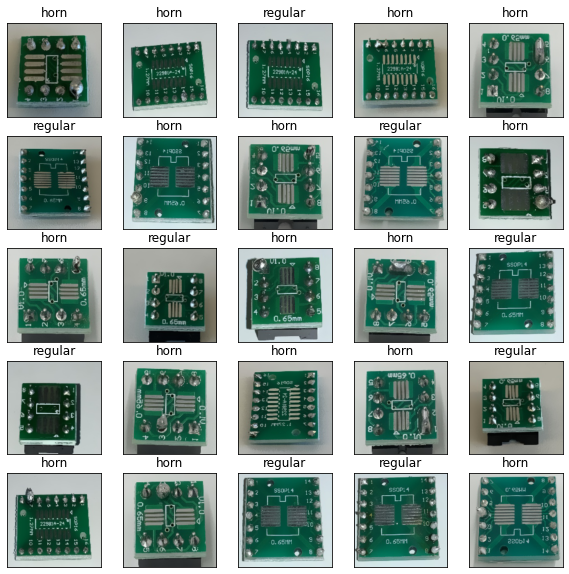

In [345]:

plt.figure(figsize=(10,10))  # 画像の表示サイズ
for i in range(n_image):
    plt.subplot(5,5,i+1)
    plt.imshow(np.transpose(images[i], (1,2,0))) # チャンネルを一番後ろに
    label = img_classes[labels[i]]
    plt.title(label)
    plt.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)  # ラベルとメモリを非表示に

plt.show()

In [347]:
# ミニバッチのサイズを指定
batch_size = 5

# DataLoaderを作成
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True)

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False)

# 辞書型変数にまとめる
dataloaders_dict = {"train": train_dataloader, "val": val_dataloader, "test": test_dataloader }

# 動作確認
batch_iterator = iter(dataloaders_dict["train"])  # イテレータに変換
inputs, labels = next(
    batch_iterator)  # 1番目の要素を取り出す
print(inputs.size())
print(labels)

torch.Size([5, 3, 224, 224])
tensor([0, 0, 1, 1, 1])


In [348]:
dataset_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset),
    'test' : len(test_dataset)
}

In [349]:
# GPU/CPUが使えるかどうか確認
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 学習済みのVGG-16モデルをロード
# VGG-16モデルのインスタンスを生成
use_pretrained = True  # 学習済みのパラメータを使用
net = models.vgg16(pretrained=use_pretrained)

# VGG16の最後の出力層の出力ユニットを2カテゴリに付け替える
net.classifier[6] = nn.Linear(in_features=4096, out_features=2)

# 訓練モードに設定
net.train()

print('ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました')

ネットワーク設定完了：学習済みの重みをロードし、訓練モードに設定しました


In [350]:
net = net.to(device)

In [351]:
# 損失関数の設定
criterion = nn.CrossEntropyLoss()


In [352]:
# ファインチューニングで学習させるパラメータを、変数params_to_updateの1～3に格納する

params_to_update_1 = []
params_to_update_2 = []
params_to_update_3 = []

# 学習させる層のパラメータ名を指定
update_param_names_1 = ["features"]
update_param_names_2 = ["classifier.0.weight",
                        "classifier.0.bias", "classifier.3.weight", "classifier.3.bias"]
update_param_names_3 = ["classifier.6.weight", "classifier.6.bias"]

# パラメータごとに各リストに格納する
for name, param in net.named_parameters():
    if update_param_names_1[0] in name:
        param.requires_grad = True
        params_to_update_1.append(param)
        print("params_to_update_1に格納：", name)

    elif name in update_param_names_2:
        param.requires_grad = True
        params_to_update_2.append(param)
        print("params_to_update_2に格納：", name)

    elif name in update_param_names_3:
        param.requires_grad = True
        params_to_update_3.append(param)
        print("params_to_update_3に格納：", name)

    else:
        param.requires_grad = False
        print("勾配計算なし。学習しない：", name)


# # 転移学習で学習させるパラメータを、変数params_to_updateに格納する
# params_to_update = []

# # 学習させるパラメータ名
# update_param_names = ["classifier.6.weight", "classifier.6.bias"]

# # 学習させるパラメータ以外は勾配計算をなくし、変化しないように設定
# for name, param in net.named_parameters():
#     if name in update_param_names:
#         param.requires_grad = True
#         params_to_update.append(param)
#         print(name)
#     else:
#         param.requires_grad = False

# # params_to_updateの中身を確認
# print("-----------")
# print(params_to_update)




params_to_update_1に格納： features.0.weight
params_to_update_1に格納： features.0.bias
params_to_update_1に格納： features.2.weight
params_to_update_1に格納： features.2.bias
params_to_update_1に格納： features.5.weight
params_to_update_1に格納： features.5.bias
params_to_update_1に格納： features.7.weight
params_to_update_1に格納： features.7.bias
params_to_update_1に格納： features.10.weight
params_to_update_1に格納： features.10.bias
params_to_update_1に格納： features.12.weight
params_to_update_1に格納： features.12.bias
params_to_update_1に格納： features.14.weight
params_to_update_1に格納： features.14.bias
params_to_update_1に格納： features.17.weight
params_to_update_1に格納： features.17.bias
params_to_update_1に格納： features.19.weight
params_to_update_1に格納： features.19.bias
params_to_update_1に格納： features.21.weight
params_to_update_1に格納： features.21.bias
params_to_update_1に格納： features.24.weight
params_to_update_1に格納： features.24.bias
params_to_update_1に格納： features.26.weight
params_to_update_1に格納： features.26.bias
params_to_update_1に格納： f

In [353]:
# 最適化手法の設定
optimizer = optim.SGD([
    {'params': params_to_update_1, 'lr': 1e-4},
    {'params': params_to_update_2, 'lr': 5e-4},
    {'params': params_to_update_3, 'lr': 1e-3}
])

# # 最適化アルゴリズム
# optimizer = optim.Adam(net.parameters())

In [354]:
# モデルを学習させる関数を作成


# def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

#     # 初期設定
#     # GPUが使えるかを確認
#     device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#     print("使用デバイス：", device)

#     # ネットワークをGPUへ
#     net.to(device)

#     # ネットワークがある程度固定であれば、高速化させる
#     torch.backends.cudnn.benchmark = True

#     # epochのループ
#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch+1, num_epochs))
#         print('-------------')

#         # epochごとの訓練と検証のループ
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 net.train()  # モデルを訓練モードに
#             else:
#                 net.eval()   # モデルを検証モードに

#             epoch_loss = 0.0  # epochの損失和
#             epoch_corrects = 0  # epochの正解数

#             # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
#             if (epoch == 0) and (phase == 'train'):
#                 continue

#             # データローダーからミニバッチを取り出すループ
#             for inputs, labels in tqdm(dataloaders_dict[phase]):

#                 # GPUが使えるならGPUにデータを送る
#                 inputs = inputs.to(device)
#                 labels = labels.to(device)

#                 # optimizerを初期化
#                 optimizer.zero_grad()

#                 # 順伝搬（forward）計算
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = net(inputs)
#                     loss = criterion(outputs, labels)  # 損失を計算
#                     _, preds = torch.max(outputs, 1)  # ラベルを予測

#                     # 訓練時はバックプロパゲーション
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                     # 結果の計算
#                     epoch_loss += loss.item() * inputs.size(0)  # lossの合計を更新
#                     # 正解数の合計を更新
#                     epoch_corrects += torch.sum(preds == labels.data)

#             # epochごとのlossと正解率を表示
#             epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
#             epoch_acc = epoch_corrects.double(
#             ) / len(dataloaders_dict[phase].dataset)

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                 phase, epoch_loss, epoch_acc))

def train(model, dataloaders, otpimizer, criterion, num_epochs, device):
    """
    model:学習モデル
    dataloader:学習、評価データのdataloader
    optimizer:最適化関数
    crierion:ロス関数
    num_epochs:学習回数
    device:CPUかGPUか
    """
    best_acc = 0.0
    # 学習を繰り返す
    for epoch in range(num_epochs):
        # trainとvalを繰り返す
        for phase in ['train', 'val']:
            # モデルを学習モードか評価モードに切り替える
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            # 精度計算用
            loss_sum = 0.0
            acc_sum = 0.0
            total = 0

            # 進捗の表示
            with tqdm(total=len(dataloaders[phase]),unit="batch") as pbar:
                pbar.set_description(f"Epoch[{epoch}/{num_epochs}]({phase})")
                
                # dataloadersからバッチサイズに応じてデータを取得
                for inputs, labels in dataloaders[phase]:
                    # 画像とラベルをGPU/CPUか切り替え
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # 予測
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    
                    # ロス算出
                    loss = criterion(outputs, labels)
                    
                    # 予測とラベルの差を使って学習 
                    if phase == 'train':
                        # ここは決まり文句
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    # ロス、精度を算出
                    total += inputs.size(0)
                    loss_sum += loss.item() * inputs.size(0)
                    acc_sum += torch.sum(preds == labels.data).item()
                    
                    # 進捗の表示
                    pbar.set_postfix({"loss":loss_sum/float(total),"accuracy":float(acc_sum)/float(total)})
                    pbar.update(1)

            # 1エポックでのロス、精度を算出
            epoch_loss = loss_sum / dataset_sizes[phase]
            epoch_acc = acc_sum / dataset_sizes[phase]
            
            # 一番良い制度の時にモデルデータを保存
            if phase == 'val' and epoch_acc > best_acc:
                print(f"save model epoch:{epoch} loss:{epoch_loss} acc:{epoch_acc}")
                torch.save(model, 'best_model.pth')



In [355]:
# # 学習・検証を実行する
# num_epochs=3
# train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

num_epochs = 40
train(net, dataloaders_dict, optimizer, criterion, num_epochs, device)

Epoch[0/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.64batch/s, loss=0.641, accuracy=0.611]


save model epoch:0 loss:0.6409289062851005 acc:0.6111111111111112


Epoch[1/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.62batch/s, loss=0.702, accuracy=0.611]


save model epoch:1 loss:0.7021080923991071 acc:0.6111111111111112


Epoch[2/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.57batch/s, loss=0.551, accuracy=0.708]


save model epoch:2 loss:0.5505697770665089 acc:0.7083333333333334


Epoch[3/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.59batch/s, loss=0.522, accuracy=0.764]


save model epoch:3 loss:0.5217238337629371 acc:0.7638888888888888


Epoch[4/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.61batch/s, loss=0.528, accuracy=0.708]


save model epoch:4 loss:0.5276701522784101 acc:0.7083333333333334


Epoch[5/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.62batch/s, loss=0.501, accuracy=0.778]


save model epoch:5 loss:0.5008485760125849 acc:0.7777777777777778


Epoch[6/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.58batch/s, loss=0.651, accuracy=0.653]


save model epoch:6 loss:0.6510103260063462 acc:0.6527777777777778


Epoch[7/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.59batch/s, loss=0.449, accuracy=0.778]


save model epoch:7 loss:0.4489332516160276 acc:0.7777777777777778


Epoch[8/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.65batch/s, loss=0.604, accuracy=0.708]


save model epoch:8 loss:0.6040517686762743 acc:0.7083333333333334


Epoch[9/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.53batch/s, loss=0.439, accuracy=0.764]


save model epoch:9 loss:0.4394314129733377 acc:0.7638888888888888


Epoch[10/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.62batch/s, loss=0.397, accuracy=0.806]


save model epoch:10 loss:0.3965557844688495 acc:0.8055555555555556


Epoch[11/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.64batch/s, loss=0.447, accuracy=0.792]


save model epoch:11 loss:0.4471920077792472 acc:0.7916666666666666


Epoch[12/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.57batch/s, loss=0.459, accuracy=0.778]


save model epoch:12 loss:0.4593262090865109 acc:0.7777777777777778


Epoch[13/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.61batch/s, loss=0.391, accuracy=0.819]


save model epoch:13 loss:0.390961274297701 acc:0.8194444444444444


Epoch[14/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.61batch/s, loss=0.513, accuracy=0.778]


save model epoch:14 loss:0.51342874361823 acc:0.7777777777777778


Epoch[15/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.63batch/s, loss=0.541, accuracy=0.778]


save model epoch:15 loss:0.5412491124588996 acc:0.7777777777777778


Epoch[16/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.55batch/s, loss=0.424, accuracy=0.833]


save model epoch:16 loss:0.42438665632572437 acc:0.8333333333333334


Epoch[17/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.58batch/s, loss=0.393, accuracy=0.861]


save model epoch:17 loss:0.39323483624806005 acc:0.8611111111111112


Epoch[18/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.62batch/s, loss=0.419, accuracy=0.847]


save model epoch:18 loss:0.419260312570259 acc:0.8472222222222222


Epoch[19/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.61batch/s, loss=0.366, accuracy=0.847]


save model epoch:19 loss:0.3657531674640874 acc:0.8472222222222222


Epoch[20/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.62batch/s, loss=0.408, accuracy=0.847]


save model epoch:20 loss:0.407698068043424 acc:0.8472222222222222


Epoch[21/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.62batch/s, loss=0.366, accuracy=0.847]


save model epoch:21 loss:0.36647438620113665 acc:0.8472222222222222


Epoch[22/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.61batch/s, loss=0.38, accuracy=0.847]


save model epoch:22 loss:0.37990277979729903 acc:0.8472222222222222


Epoch[23/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.59batch/s, loss=0.485, accuracy=0.833]


save model epoch:23 loss:0.48526720876624396 acc:0.8333333333333334


Epoch[24/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.60batch/s, loss=0.435, accuracy=0.833]


save model epoch:24 loss:0.4352123859959344 acc:0.8333333333333334


Epoch[25/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.59batch/s, loss=0.352, accuracy=0.847]


save model epoch:25 loss:0.35196531620911425 acc:0.8472222222222222


Epoch[26/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.61batch/s, loss=0.419, accuracy=0.847]


save model epoch:26 loss:0.4193298751229627 acc:0.8472222222222222


Epoch[27/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.64batch/s, loss=0.403, accuracy=0.861]


save model epoch:27 loss:0.4025719146334773 acc:0.8611111111111112


Epoch[28/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.60batch/s, loss=0.486, accuracy=0.861]


save model epoch:28 loss:0.48556141182133516 acc:0.8611111111111112


Epoch[29/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.64batch/s, loss=0.383, accuracy=0.847]


save model epoch:29 loss:0.38305999152362347 acc:0.8472222222222222


Epoch[30/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.58batch/s, loss=0.373, accuracy=0.833]


save model epoch:30 loss:0.37320908438414335 acc:0.8333333333333334


Epoch[31/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.66batch/s, loss=0.424, accuracy=0.819]


save model epoch:31 loss:0.4236908290638692 acc:0.8194444444444444


Epoch[32/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.65batch/s, loss=0.438, accuracy=0.833]


save model epoch:32 loss:0.4382745835658473 acc:0.8333333333333334


Epoch[33/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.68batch/s, loss=0.49, accuracy=0.861]


save model epoch:33 loss:0.4899367661807143 acc:0.8611111111111112


Epoch[34/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.68batch/s, loss=0.465, accuracy=0.847]


save model epoch:34 loss:0.46487751276516875 acc:0.8472222222222222


Epoch[35/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.59batch/s, loss=0.603, accuracy=0.833]


save model epoch:35 loss:0.6032242864619346 acc:0.8333333333333334


Epoch[36/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.66batch/s, loss=0.452, accuracy=0.861]


save model epoch:36 loss:0.45235146391658215 acc:0.8611111111111112


Epoch[37/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.57batch/s, loss=0.412, accuracy=0.833]


save model epoch:37 loss:0.411985308106523 acc:0.8333333333333334


Epoch[38/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.62batch/s, loss=0.407, accuracy=0.847]


save model epoch:38 loss:0.4074275072909788 acc:0.8472222222222222


Epoch[39/40](val): 100%|██████████| 15/15 [00:01<00:00,  7.61batch/s, loss=0.429, accuracy=0.833]


save model epoch:39 loss:0.4292996680208792 acc:0.8333333333333334


In [356]:
# # 今回学習したモデルでテスト
# best_model = torch.load('best_model.pth')

In [357]:
# best_model.eval()

In [358]:
import copy
from sklearn.metrics import classification_report
netcpu = copy.deepcopy(net).to('cpu')
pred = []
Y = []
for i, (x,y) in enumerate(test_dataloader):
    with torch.no_grad():
        output = netcpu(x)
    pred += [int(l.argmax()) for l in output]
    Y += [int(l) for l in y]

print(classification_report(Y, pred))

              precision    recall  f1-score   support

           0       1.00      0.59      0.74       213
           1       0.00      0.00      0.00         0

    accuracy                           0.59       213
   macro avg       0.50      0.30      0.37       213
weighted avg       1.00      0.59      0.74       213



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [369]:
len(np.array(pred[1:]))

212

In [371]:
# テストデータから予測を作成する関数
def pred_model(net, dataloaders_dict, criterion, optimizer):
  

  phase = 'test'
  net.eval()   # モデルを検証モードに

  # 提出データ作成用の入れ物を作成
  subT = torch.randn(1)

  # データローダーからミニバッチを取り出すループ
  for inputs, labels in tqdm(dataloaders_dict[phase]):
    # optimizerを初期化
    optimizer.zero_grad()
    #学習したモデルで、予測を実施
    outputs = net(inputs)
    _, preds = torch.max(outputs, 1)  # ラベルを予測
    #print(subT.shape,preds.shape)
    subT = torch.cat([subT,preds])
  #print(subT.shape)
  return subT

In [372]:
#　テストデータから予測の実行
sub = pred_model(netcpu, dataloaders_dict, criterion, optimizer)

100%|██████████| 43/43 [01:52<00:00,  2.62s/it]


In [373]:
#予測結果をCPU上のnumpy配列に変換
xnumpy = sub.to('cpu').detach().numpy().copy()

In [374]:
len(xnumpy[1:])


213

In [376]:
import pandas as pd 
sublabel = pd.DataFrame(xnumpy[1:]) #　予測値をデータフレームに格納
# sublabel = pd.DataFrame(np.array(pred[1:]))
sublabel.columns = ['sub'] #　列名を提出で指定されたsubにする
sublabel = sublabel.astype(int) # 予測値を整数（０か１）に変換

subdf = pd.DataFrame(test_list) # testデータのファイルリストを取得
filelist = subdf[0].str.split('/',expand=True) #　ファイル名だけ抽出

# ファイル名のリストと、予測値を結合
subfin = pd.concat([filelist,sublabel],axis=1).reset_index(drop=True)
sortedsub=subfin.sort_values(4) #　ファイル名順に並べ替え
lastsub = sortedsub[[4,'sub']] #　必要な列だけに絞り込み

#提出ファイルを保存
lastsub.to_csv('009-submit.tsv',header=False, index=False, sep='\t') 

In [219]:
filelist

,0,1,2,3,4
0,.,Data,kiban,test,000.jpeg
1,.,Data,kiban,test,001.jpeg
2,.,Data,kiban,test,002.jpeg
3,.,Data,kiban,test,003.jpeg
4,.,Data,kiban,test,004.jpeg
...,...,...,...,...,...
208,.,Data,kiban,test,208.jpeg
209,.,Data,kiban,test,209.jpeg
210,.,Data,kiban,test,210.jpeg
211,.,Data,kiban,test,211.jpeg


In [ ]:
from sklearn.metrics import classification_report

pred = []
Y = []

In [ ]:
for i, (x,y) in enumerate(test_dataloader):
        with torch.no_grad():
            output = best_model(x)
            pred += [int(l.argmax()) for l in output]
            Y += [int(l) for l in y]

#print(classification_report(Y, pred))

In [ ]:
pred

[]

In [ ]:
img_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)



In [ ]:
from IPython import display

for batch in img_loader:
    inputs = batch["image"].to(device)
    outputs = best_model(inputs)

    # batch_probs = F.softmax(outputs, dim=1)

    # batch_probs, batch_indices = batch_probs.sort(dim=1, descending=True)

    # for probs, indices, path in zip(batch_probs, batch_indices, batch["path"]):
    #     display.display(display.Image(path, width=224))
    #     print(f"path: {path}")
    #     for k in range(3):
    #         print(f"Top-{k + 1} {probs[k]:.2%} {class_names[indices[k]]}")

In [ ]:
outputs

NameError: ignored

In [ ]:
# モデルを学習させる関数を作成


# def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

#     # epochのループ
#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch+1, num_epochs))
#         print('-------------')

#         # epochごとの学習と検証のループ
#         for phase in ['train', 'val']:
#             if phase == 'train':
#                 net.train()  # モデルを訓練モードに
#             else:
#                 net.eval()   # モデルを検証モードに

#             epoch_loss = 0.0  # epochの損失和
#             epoch_corrects = 0  # epochの正解数

#             # 未学習時の検証性能を確かめるため、epoch=0の訓練は省略
#             if (epoch == 0) and (phase == 'train'):
#                 continue

#             # データローダーからミニバッチを取り出すループ
#             for inputs, labels in tqdm(dataloaders_dict[phase]):

#                 # optimizerを初期化
#                 optimizer.zero_grad()

#                 # 順伝搬（forward）計算
#                 with torch.set_grad_enabled(phase == 'train'):
#                     outputs = net(inputs)
#                     loss = criterion(outputs, labels)  # 損失を計算
#                     _, preds = torch.max(outputs, 1)  # ラベルを予測
                    
  
#                     # 訓練時はバックプロパゲーション
#                     if phase == 'train':
#                         loss.backward()
#                         optimizer.step()

#                     # イタレーション結果の計算
#                     # lossの合計を更新
#                     epoch_loss += loss.item() * inputs.size(0)  
#                     # 正解数の合計を更新
#                     epoch_corrects += torch.sum(preds == labels.data)

#             # epochごとのlossと正解率を表示
#             epoch_loss = epoch_loss / len(dataloaders_dict[phase].dataset)
#             epoch_acc = epoch_corrects.double(
#             ) / len(dataloaders_dict[phase].dataset)

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(
#                 phase, epoch_loss, epoch_acc))

In [ ]:
# 学習・検証を実行する
num_epochs=4
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Epoch 1/4
-------------


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
100%|██████████| 8/8 [00:51<00:00,  6.38s/it]


val Loss: 1.4068 Acc: 0.1806
Epoch 2/4
-------------


100%|██████████| 22/22 [02:34<00:00,  7.02s/it]


train Loss: 1.3536 Acc: 0.3440


100%|██████████| 8/8 [00:50<00:00,  6.27s/it]


val Loss: 1.1873 Acc: 0.5139
Epoch 3/4
-------------


100%|██████████| 22/22 [02:33<00:00,  7.00s/it]


train Loss: 1.2079 Acc: 0.4679


100%|██████████| 8/8 [00:51<00:00,  6.40s/it]


val Loss: 1.1957 Acc: 0.4861
Epoch 4/4
-------------


100%|██████████| 22/22 [02:34<00:00,  7.02s/it]


train Loss: 1.0949 Acc: 0.4587


100%|██████████| 8/8 [00:49<00:00,  6.20s/it]

val Loss: 1.1471 Acc: 0.4861


In [ ]:
net.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# 予測用のダミーデータ
x = torch.randn(3, 3, 300, 300)

# 予測の実行
preds = net(x)

In [ ]:
preds

tensor([[-2.9338, -2.2194, -0.1124, -1.2080],
        [-2.9831, -2.1947, -0.0780, -1.1162],
        [-3.0211, -2.2673, -0.0662, -1.0823]], grad_fn=<AddmmBackward>)